In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('ads_hour.csv', index_col=['Date'], parse_dates=['Date'])

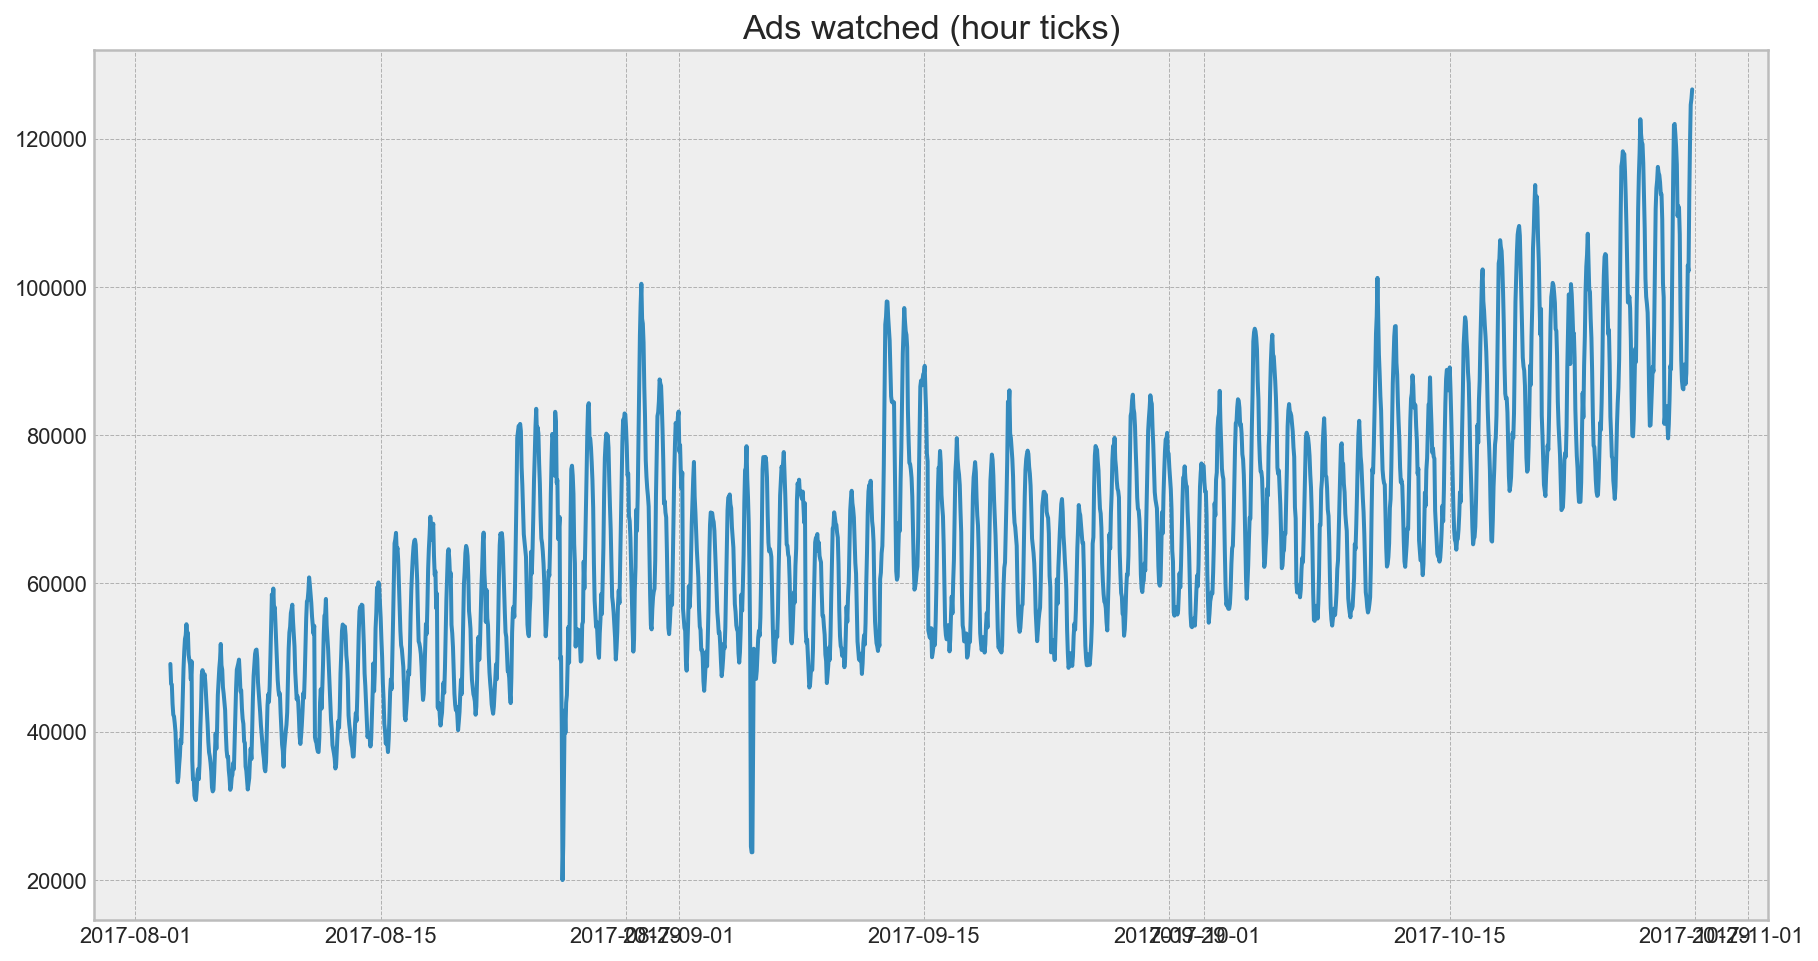

In [4]:
with plt.style.context('bmh'):    
    plt.figure(figsize=(15, 8))
    plt.title('Ads watched (hour ticks)')
    plt.plot(data.ads);

In [5]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [6]:
data.shape

(2085, 1)

In [7]:
n_steps = 50
serie = np.empty((2025, n_steps+10, 1))
for i in range(2025):
    serie[i,:,:] = data[i:i+n_steps+10]

In [8]:
# X_train, Y_train = serie[:1500, :n_steps], serie[:1500, -10:, 0]
# X_test, Y_test = serie[1500:, :n_steps], serie[1500:, -10:, 0]
X = serie[:, :n_steps]
Y = np.empty((2025, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = serie[:, step_ahead:step_ahead + n_steps, 0]
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,shuffle=False ,random_state=42)

In [9]:
serie.shape,Y_train.shape,X_train.shape

((2025, 60, 1), (1518, 50, 10), (1518, 50, 1))

In [10]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [12]:
history = model.fit(X_train, Y_train, epochs=50,validation_data=(X_test, Y_test))

Train on 1518 samples, validate on 507 samples
Epoch 1/50
1518/1518 [==============================] - 3s 2ms/sample - loss: 0.0992 - last_time_step_mse: 0.0958 - val_loss: 0.0876 - val_last_time_step_mse: 0.0658
Epoch 2/50
1518/1518 [==============================] - 0s 230us/sample - loss: 0.0190 - last_time_step_mse: 0.0134 - val_loss: 0.0303 - val_last_time_step_mse: 0.0208
Epoch 3/50
1518/1518 [==============================] - 0s 228us/sample - loss: 0.0115 - last_time_step_mse: 0.0087 - val_loss: 0.0207 - val_last_time_step_mse: 0.0128
Epoch 4/50
1518/1518 [==============================] - 0s 229us/sample - loss: 0.0091 - last_time_step_mse: 0.0066 - val_loss: 0.0138 - val_last_time_step_mse: 0.0080
Epoch 5/50
1518/1518 [==============================] - 0s 230us/sample - loss: 0.0065 - last_time_step_mse: 0.0042 - val_loss: 0.0082 - val_last_time_step_mse: 0.0042
Epoch 6/50
1518/1518 [==============================] - 0s 232us/sample - loss: 0.0049 - last_time_step_mse: 0.0029

In [18]:
pred = model.predict(X_test)

In [19]:
plot_y = np.empty((525, 60))
plt_pred = np.empty((525, 60))

plot_y = np.hstack((Y_test[:,:,0],Y_test[:,49,:]))
plt_pred = np.hstack((pred[:,:,0],pred[:,49,:]))

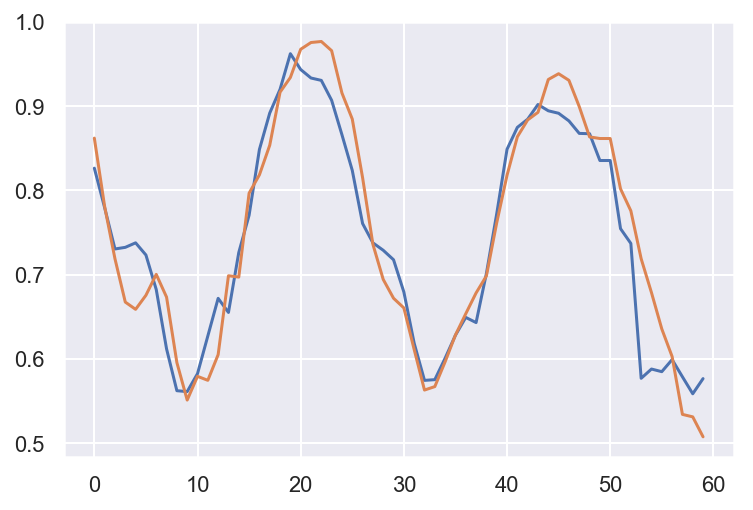

In [20]:
index = 475;
sns.lineplot(data=plot_y[index,:])
sns.lineplot(data=plt_pred[index,:])

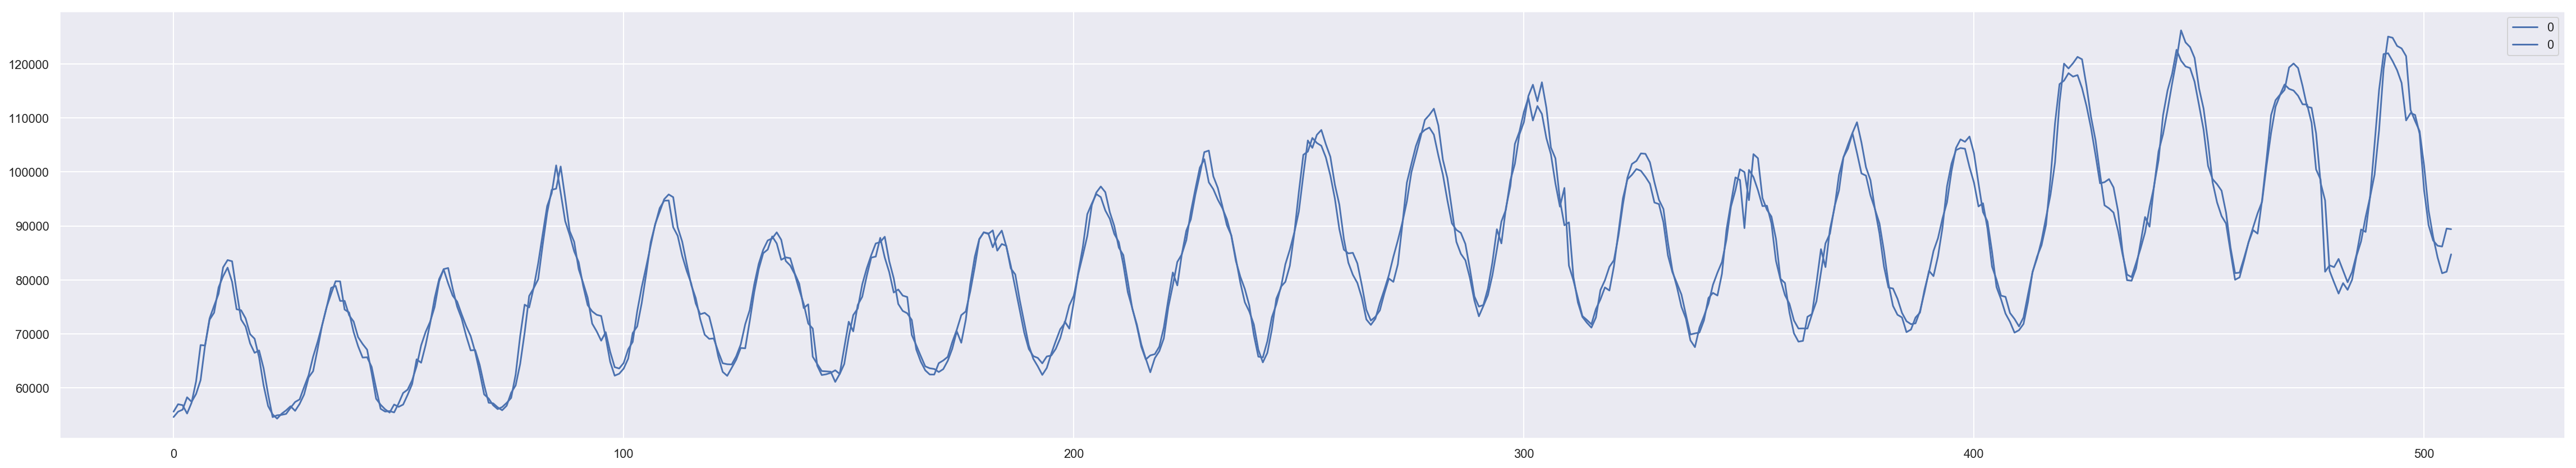

In [22]:
pred1 = np.empty((525))
pred1 = scaler.inverse_transform(pred[:,49,0].reshape(-1,1))
y1 = scaler.inverse_transform(Y_test[:,49,0].reshape(-1,1))

plt.figure(figsize=(40,7))
sns.lineplot(data=pred1)
sns.lineplot(data=y1)

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae  = mean_absolute_error(pred1, y1)
mape = mean_absolute_percentage_error(pred1, y1)
mae,mape

(2077.041427822978, 2.422625441850362)

Text(0.5, 1.0, 'MAE 1809.0, MAPE 2.8%')

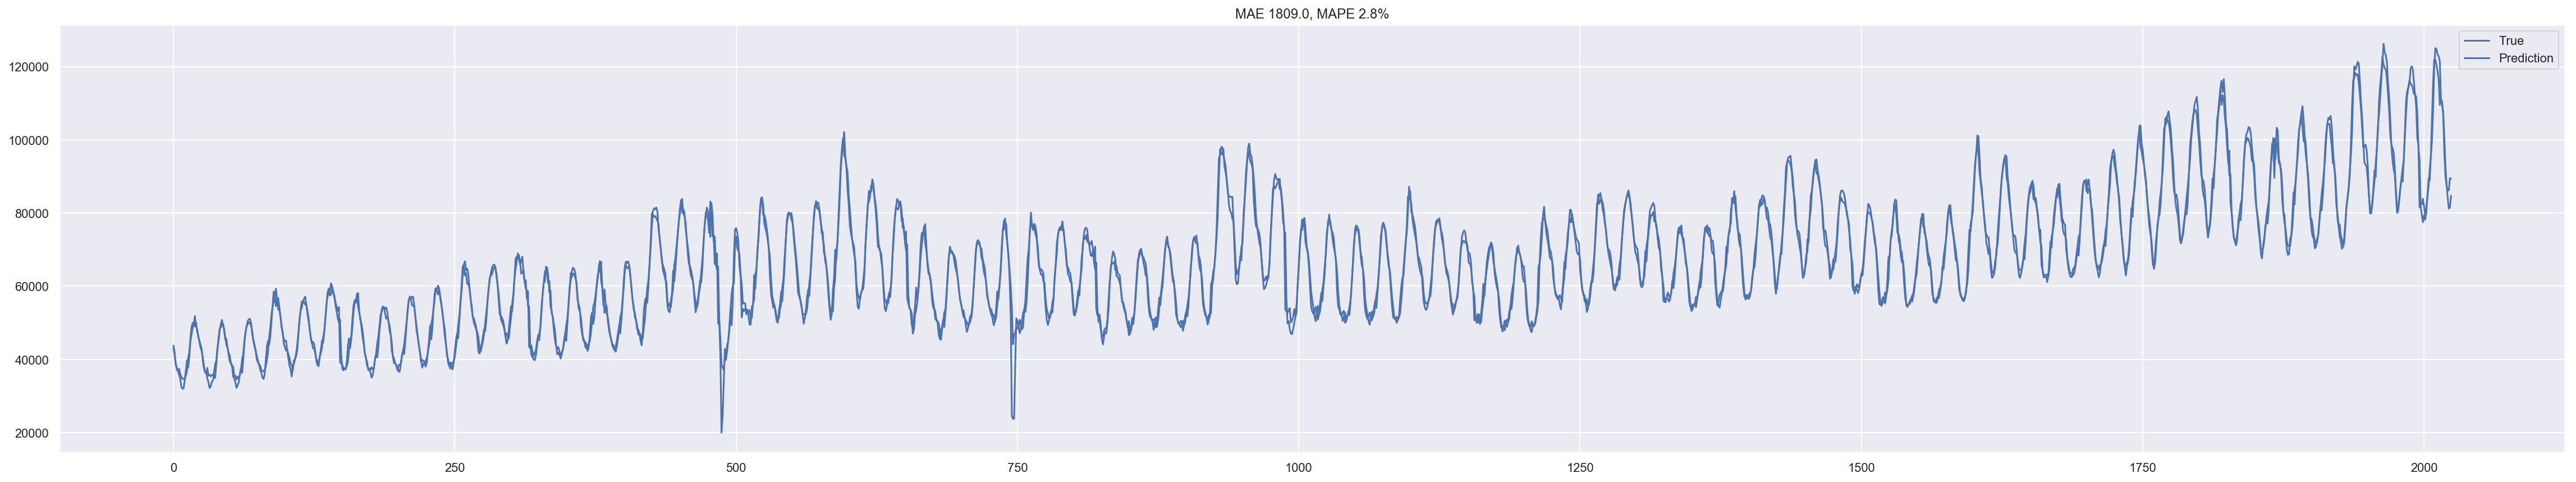

In [26]:
full_pred=model.predict(X)
plt.figure(figsize=(40,7))
nb_input = 50
steps_ahead = 1
plt_Y = scaler.inverse_transform(Y[:,nb_input-1,steps_ahead-1].reshape(-1,1))
plt_pred = scaler.inverse_transform(full_pred[:,nb_input-1,steps_ahead-1].reshape(-1,1))

mae  = mean_absolute_error(plt_pred, plt_Y)
mape = mean_absolute_percentage_error(plt_pred, plt_Y)

sns.lineplot(data=plt_Y)
sns.lineplot(data=plt_pred)
plt.legend(labels=['True','Prediction'])
plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))